# Lesson: Bayesian Hierarchical Linear Regression

You will learn about:

1. Pooled and unpooled models are unsatisfying
    - There are *similarities* between parameters of different groups
    - Pooled and unpooled models unsatisfying answer

2. Partial pooling aka hierarchical modeling
    - Allows for modeling *similarities* but also *differences*
    - PyMC model with Bayesian workflow

3. Hierarchical explorations
  * What does the hierarchy actually *do*?
  * Smart regularization

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import warnings
from IPython.display import Image

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

# filter out Seaborn UserWarnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
    module=r'seaborn'
)

# Let's look at the data again

In [2]:
fish_market = pd.read_csv("data/fish-market.csv")
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")
fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)
fish_reduced = fish_market[fish_market["Weight"] != 0].copy()
fish_market

/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Species,Weight,Length1,Height,Width,log_width,log_height,log_length,log_weight
0,Bream,242.0,23.2,11.5200,4.0200,1.391282,2.444085,3.144152,5.488938
1,Bream,290.0,24.0,12.4800,4.3056,1.459917,2.524127,3.178054,5.669881
2,Bream,340.0,23.9,12.3778,4.6961,1.546732,2.515905,3.173878,5.828946
3,Bream,363.0,26.3,12.7300,4.4555,1.494139,2.543961,3.269569,5.894403
4,Bream,430.0,26.5,12.4440,5.1340,1.635885,2.521239,3.277145,6.063785
...,...,...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,2.0904,1.3936,0.331890,0.737355,2.442347,2.501436
155,Smelt,13.4,11.7,2.4300,1.2690,0.238229,0.887891,2.459589,2.595255
156,Smelt,12.2,12.1,2.2770,1.2558,0.227773,0.822859,2.493205,2.501436
157,Smelt,19.7,13.2,2.8728,2.0672,0.726195,1.055287,2.580217,2.980619


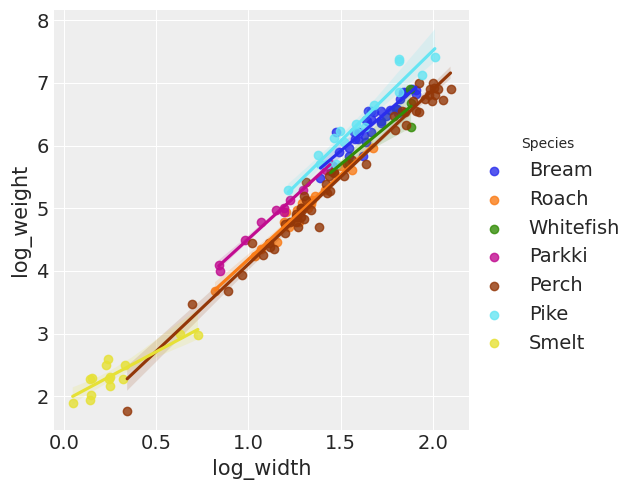

In [3]:
sns.lmplot(
    data=fish_reduced,
    x="log_width",
    y="log_weight",
    hue="Species",
    #height=3,
);

We can see that while there are differences between how width and weight correlate (especially in the intercept), there are large similarities too.

# Two (unsatisfying) Options

1. Pooled: Everything is exactly the same
2. Unpooled: Everything is different and shares not similarities

We can clearly see that neither of these are true in this data.

# What Do The Similarities Look Like?

In order to look at how similar the parameters (intercepts and slopes) are, let's run the unpooled model from the previous lesson.

As things will get more complicated in the model structure soon, here we will only take a single regression: `width`.

In [12]:
fish_test = fish_reduced.sample(frac=0.1, random_state=RANDOM_SEED).sort_index()
test_idx = fish_test.index
fish_train = fish_reduced.loc[fish_reduced.index.difference(test_idx)]

species_idx, species = fish_train.Species.factorize(sort=True)
COORDS = {
    "slopes": ["width_effect"], #, "height_effect", "length_effect"],
    "species": species,
}

COORDS

{'slopes': ['width_effect'],
 'species': Index(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'], dtype='object')}

In [13]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_unpooled_oos:
    # data
    log_width = pm.MutableData("log_width", fish_train.log_width.values)
    log_weight = pm.MutableData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    # priors
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("species"))

    # linear regression
    mu = pm.Deterministic("mu", intercept[species_idx_] + β[species_idx_] * log_width)
    
    # observational noise
    sigma = pm.HalfNormal("sigma", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=sigma,
        observed=log_weight,
    )

    # sampling
    idata_unpooled_oos = pm.sample()
    idata_unpooled_oos.extend(pm.sample_prior_predictive())
    idata_unpooled_oos.extend(pm.sample_posterior_predictive(idata_unpooled_oos))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, sigma]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


# Let's Look at the *Distribution* of Intercepts

/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='intercept', ylabel='Density'>

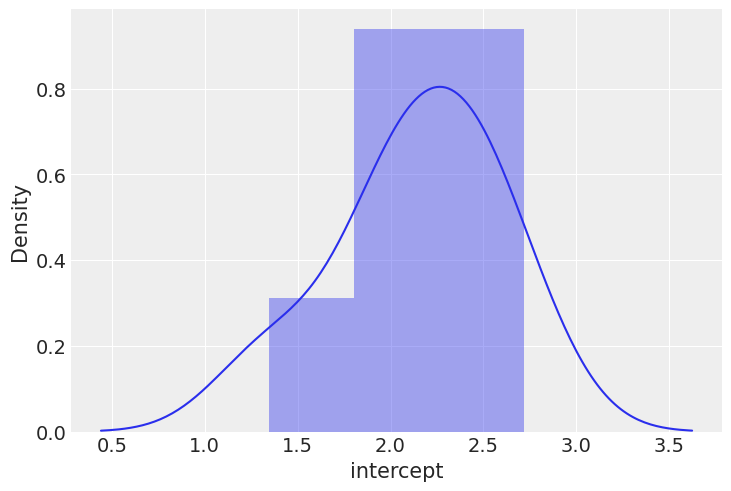

In [40]:
df_plot = idata_unpooled_oos.posterior["intercept"].mean(("chain", "draw")).to_dataframe().reset_index()
sns.distplot(df_plot["intercept"])

# And for Slopes...

/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='β', ylabel='Density'>

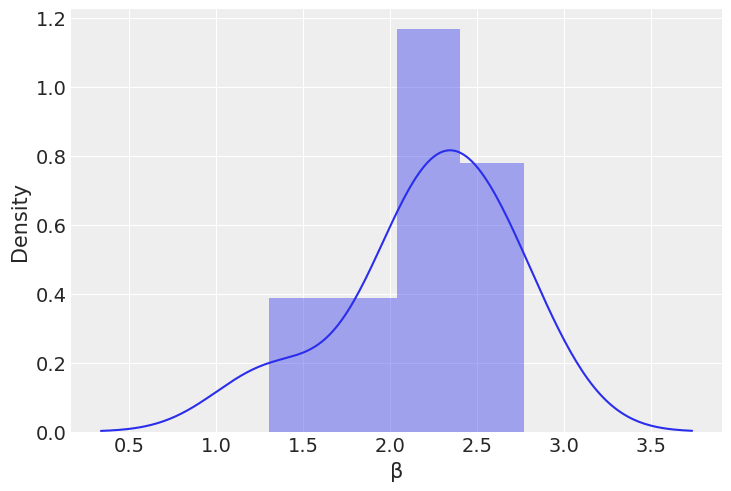

In [39]:
df_plot = idata_unpooled_oos.posterior["β"].mean(("chain", "draw")).to_dataframe().reset_index()
sns.distplot(df_plot["β"])

# Notice Anything?

# Distributions over Parameters

Just like distributions are useful for 
* specifying beliefs over individual parameters, 
* 

INSERT INCEPTION MEME

they can also be used to **model how multiple parameters**.

In [22]:
def plot_pred(idata, species="Whitefish", xlim=(1.0, 2.5), color="0.5"):
    x = np.linspace(xlim[0], xlim[1], 150)
    fish_spec = fish_reduced[fish_reduced.Species == species]
    ys = []
    for i in range(100, 150):
        y = idata.posterior["intercept"].sel(species=species, chain=0, draw=i).data + (x * idata.posterior["β"].sel(species=species, chain=0, draw=i).data) # + (x * idata_unpooled_oos.posterior["β"].sel(species=spec, slopes="height_effect", chain=0, draw=i).data) + (x * idata_unpooled_oos.posterior["β"].sel(species=spec, slopes="length_effect", chain=0, draw=i).data)# (x[:, np.newaxis] * idata_unpooled_oos.posterior["β"].sel(species=spec, chain=0, draw=i).data).sum(1)
        #y = idata_unpooled_oos.posterior["interce'pt"].sel(species=spec, chain=0, draw=i).data + (x[:, np.newaxis] * idata_unpooled_oos.posterior["β"].sel(species=spec, chain=0, draw=i).data).sum(1)
        ys.append(y)
        plt.plot(x, y, color=color, alpha=.2)

    plt.scatter(fish_spec["log_width"], fish_spec["log_weight"])

In [4]:
fish_market.groupby("Species").count()

,Weight,Length1,Height,Width,log_width,log_height,log_length,log_weight
Species,,,,,,,,
Bream,35,35,35,35,35,35,35,35
Parkki,11,11,11,11,11,11,11,11
Perch,56,56,56,56,56,56,56,56
Pike,17,17,17,17,17,17,17,17
Roach,20,20,20,20,20,20,20,20
Smelt,14,14,14,14,14,14,14,14
Whitefish,6,6,6,6,6,6,6,6


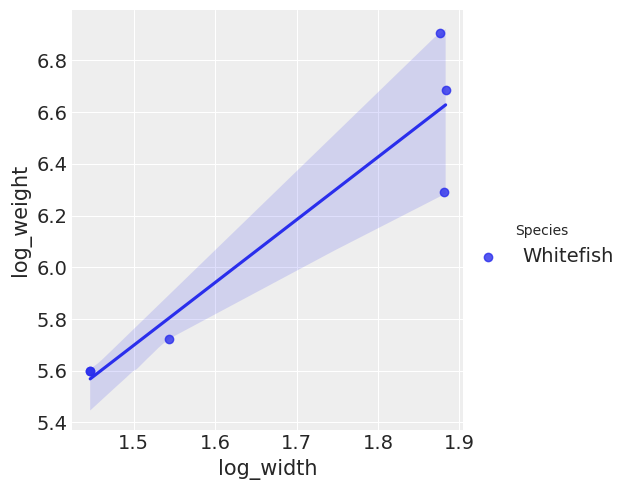

In [5]:
sns.lmplot(
    data=fish_reduced.query("Species == 'Whitefish'"),
    x="log_width",
    y="log_weight",
    hue="Species",
    #height=3,
);

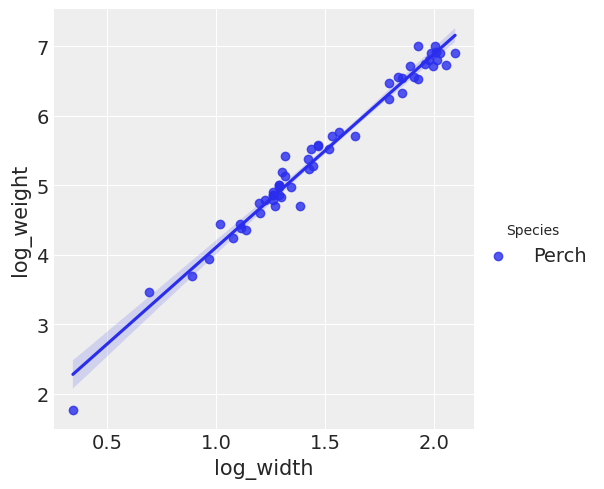

In [11]:
sns.lmplot(
    data=fish_reduced.query("Species == 'Perch'"),
    x="log_width",
    y="log_weight",
    hue="Species",
    #height=3,
);

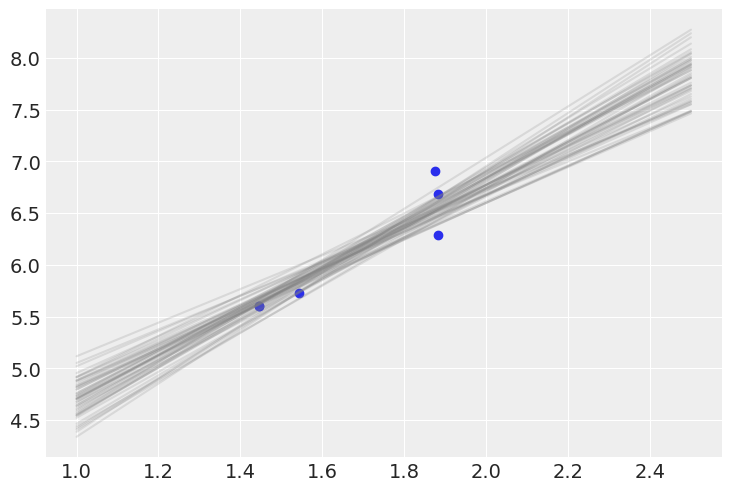

In [23]:
plot_pred(idata_unpooled_oos)

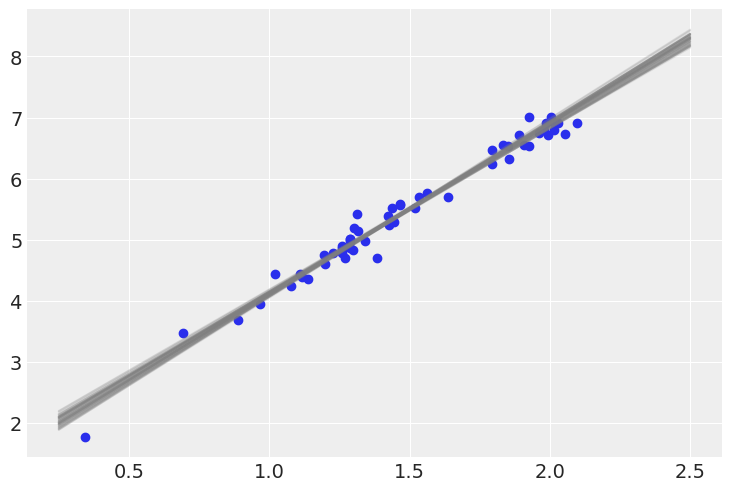

In [24]:
plot_pred(idata_unpooled_oos, species="Perch", xlim=(0.25, 2.5))

In [28]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical:
    # data
    log_width = pm.ConstantData("log_width", fish_train.log_width.values)
    log_weight = pm.ConstantData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    # priors
    group_intercept_mu = pm.Normal("group_intercept_mu", sigma=1.0)
    group_intercept_sigma = pm.HalfNormal("group_intercept_sigma", sigma=1.0)
    intercept = pm.Normal("intercept", mu=group_intercept_mu,
                          sigma=group_intercept_sigma, dims="species")
    
    group_β_mu = pm.Normal("group_β_mu", sigma=5.0)
    group_β_sigma = pm.HalfNormal("group_β_sigma", sigma=.5)
    β = pm.Normal("β", mu=group_β_mu, sigma=group_β_sigma, 
                  dims=("species"))

    # linear regression
    mu = intercept[species_idx_] + β[species_idx_] * log_width
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

    # sampling
    idata_hierarchical = pm.sample()
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept_mu, group_intercept_sigma, intercept, group_β_mu, group_β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `ta

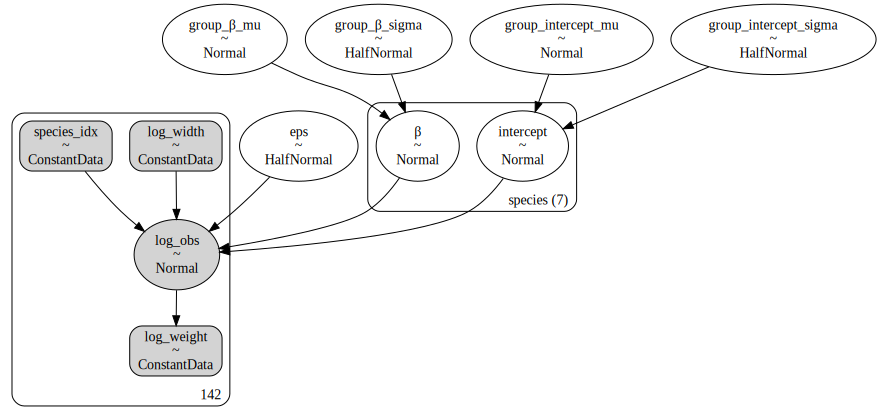

In [29]:
pm.model_to_graphviz(fish_hierarchical)

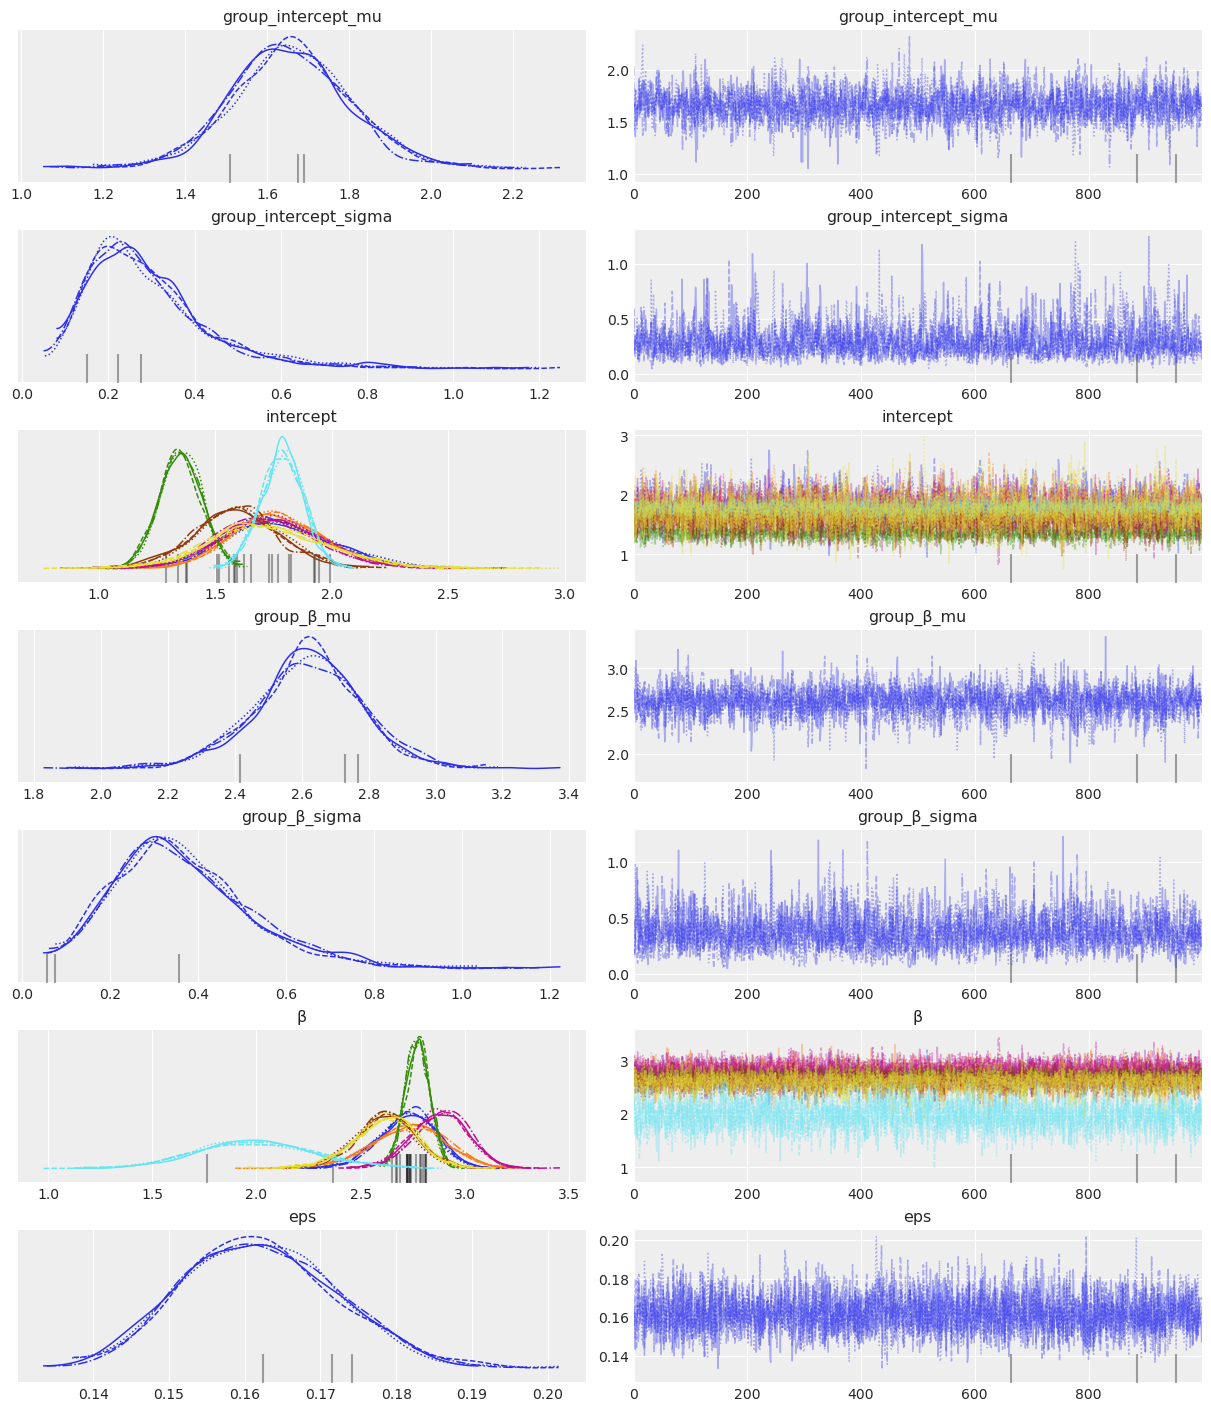

In [32]:
az.plot_trace(idata_hierarchical);

# Regression lines

TODO: Make 3 different plots so that Fahdi can tune those in

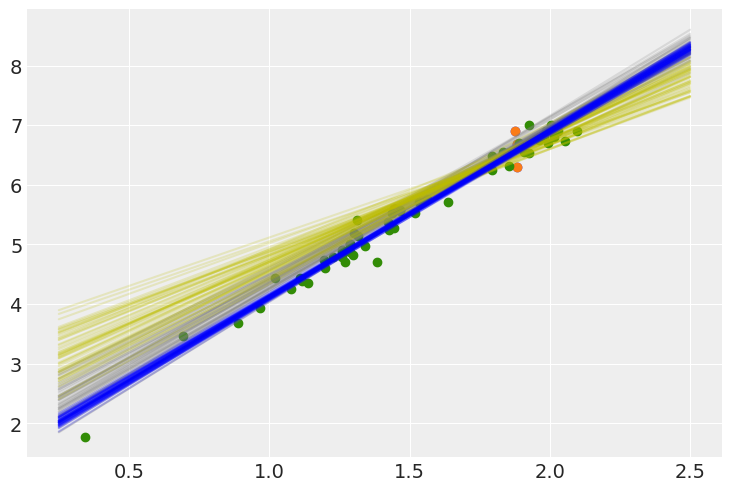

In [43]:
plot_pred(idata_hierarchical, xlim=(0.25, 2.5))
plot_pred(idata_unpooled_oos, color="y", xlim=(0.25, 2.5))
plot_pred(idata_hierarchical, species="Perch", xlim=(0.25, 2.5), color="b")

# Posterior unpooled vs hierarchical

In [63]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical_nc:
    # data
    log_width = pm.Data("log_width", fish_train.log_width.values)
    log_height = pm.Data("log_height", fish_train.log_height.values)
    log_length = pm.Data("log_length", fish_train.log_length.values)
    log_weight = pm.Data("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.Data("species_idx", species_idx)

    # priors
    group_intercept_mu = pm.Normal("group_intercept_mu", sigma=5.0)
    group_intercept_sigma = pm.HalfNormal("group_intercept_sigma", sigma=.1)
    intercept = pm.Normal("intercept", dims="species") * group_intercept_sigma + group_intercept_mu
    
    group_β_mu = pm.Normal("group_β_mu", sigma=3.5)
    group_β_sigma = pm.HalfNormal("group_β_sigma", sigma=.05)
    β = pm.Normal("β", mu=group_β_mu, sigma=group_β_sigma, dims=("species", "slopes")) #*  + group_β_mu

    # linear regression
    mu = (
        intercept[species_idx_]
        + β[species_idx_, 0] * log_width
        + β[species_idx_, 1] * log_height
        + β[species_idx_, 2] * log_length
    )
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

    # sampling
    idata_hierarchical = pm.sample(init="jitter+adapt_diag", tune=1000, target_accept=0.9)
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

/Users/twiecki/projects/pymc/pymc/data.py:640: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept_mu, group_intercept_sigma, intercept, group_β_mu, group_β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `ta

In [53]:
idata_hierarchical.posterior

<xarray.Dataset>
Dimensions:                (chain: 4, draw: 1000, species: 7)
Coordinates:
  * chain                  (chain) int64 0 1 2 3
  * draw                   (draw) int64 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * species                (species) <U9 'Bream' 'Parkki' ... 'Whitefish'
Data variables:
    group_intercept_mu     (chain, draw) float64 1.469 1.665 ... 1.51 1.483
    group_intercept_sigma  (chain, draw) float64 0.3413 0.2055 ... 0.2262 0.2989
    intercept              (chain, draw, species) float64 1.776 1.725 ... 1.873
    group_β_mu             (chain, draw) float64 2.744 2.759 ... 2.652 2.479
    group_β_sigma          (chain, draw) float64 0.2285 0.191 ... 0.2718 0.2789
    β                      (chain, draw, species) float64 2.712 2.891 ... 2.559
    eps                    (chain, draw) float64 0.1668 0.1566 ... 0.1587 0.1653
Attributes:
    created_at:                 2022-02-09T12:29:16.815918
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b2
    sampling_time:              16.021144151687622
    tuning_steps:               1000

<AxesSubplot:>

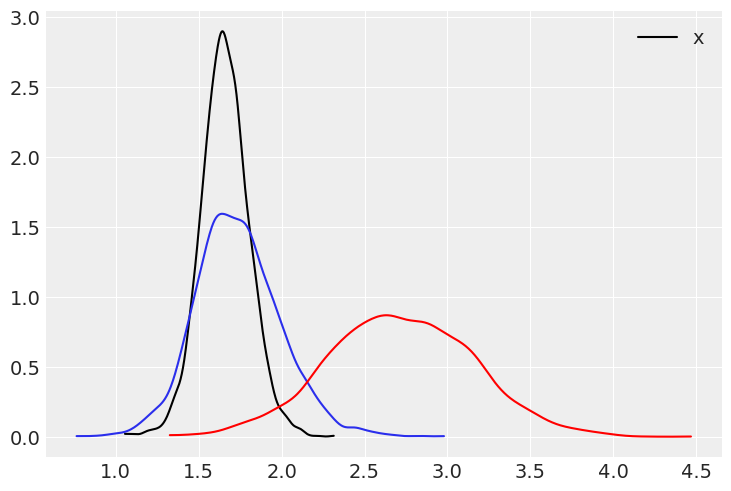

In [56]:
az.plot_dist(idata_hierarchical.posterior.group_intercept_mu, color="k", label="x")
az.plot_dist(idata_hierarchical.posterior.intercept.sel(species="Whitefish"))
az.plot_dist(idata_unpooled_oos.posterior.intercept.sel(species="Whitefish"), color="r")

<AxesSubplot:>

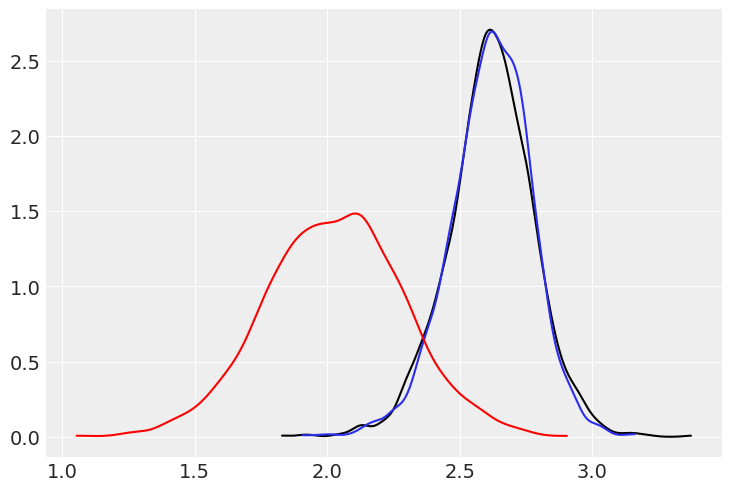

In [55]:
az.plot_dist(idata_hierarchical.posterior.group_β_mu, color="k")
az.plot_dist(idata_hierarchical.posterior.β.sel(species="Whitefish"))
az.plot_dist(idata_unpooled_oos.posterior.β.sel(species="Whitefish"), color="r")

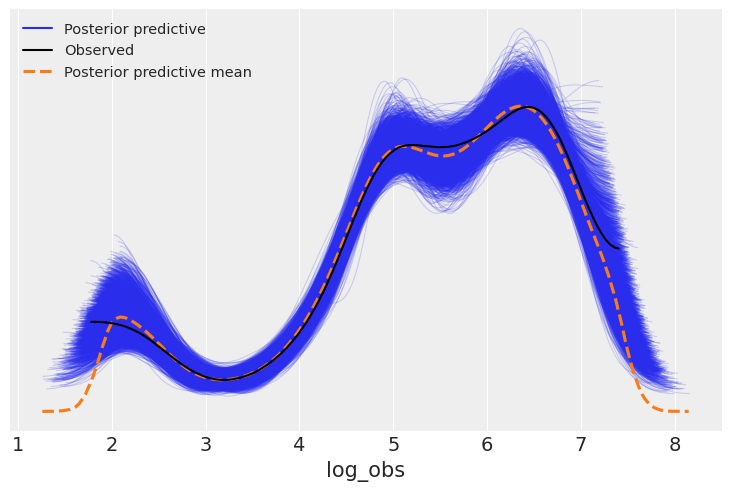

In [34]:
ax = az.plot_ppc(idata_hierarchical)
ax.set_xlabel("log_obs");

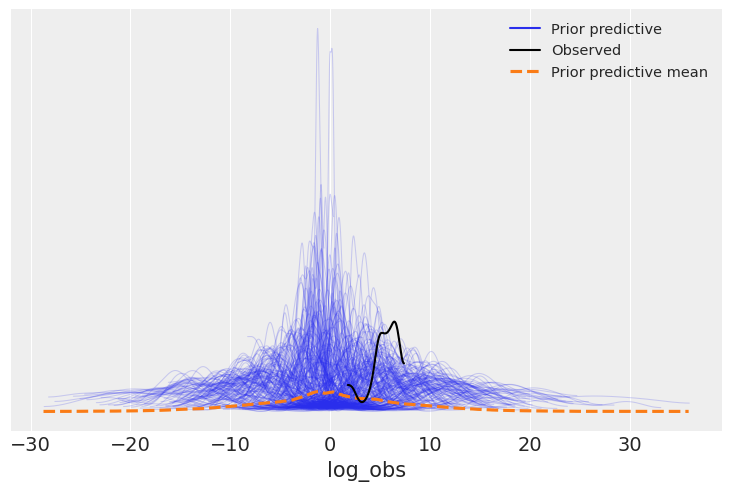

In [35]:
ax = az.plot_ppc(idata_hierarchical, group="prior")
ax.set_xlabel("log_obs");

# Hierarchical/Nested Data is Everywhere

# The Power of Bayes (tying this into the whole journey)

* Hierarchical models great example of the benefits

Look back at initial slides.

In [37]:
with fish_unpooled_oos:
    # update values of predictors:
    pm.set_data(
        {
            "log_height": fish_test.log_height.values,
            "log_length": fish_test.log_length.values,
            "log_width": fish_test.log_width.values,
            "species_idx": fish_test.Species.factorize(sort=True)[0],
        }
    )

Once that's done, we can just call `sample_posterior_predictive`. The only difference is that we're telling PyMC these are really predictions (`predictions=True`), and we want them appended to our existing `InferenceData` object (`extend_inferencedata=True`).

In [38]:
with fish_unpooled_oos:
    # use the updated values to predict outcomes:
    idata_unpooled_oos = pm.sample_posterior_predictive(
        idata_unpooled_oos,
        predictions=True,
        extend_inferencedata=True,  # not released yet, needs main branch
    )

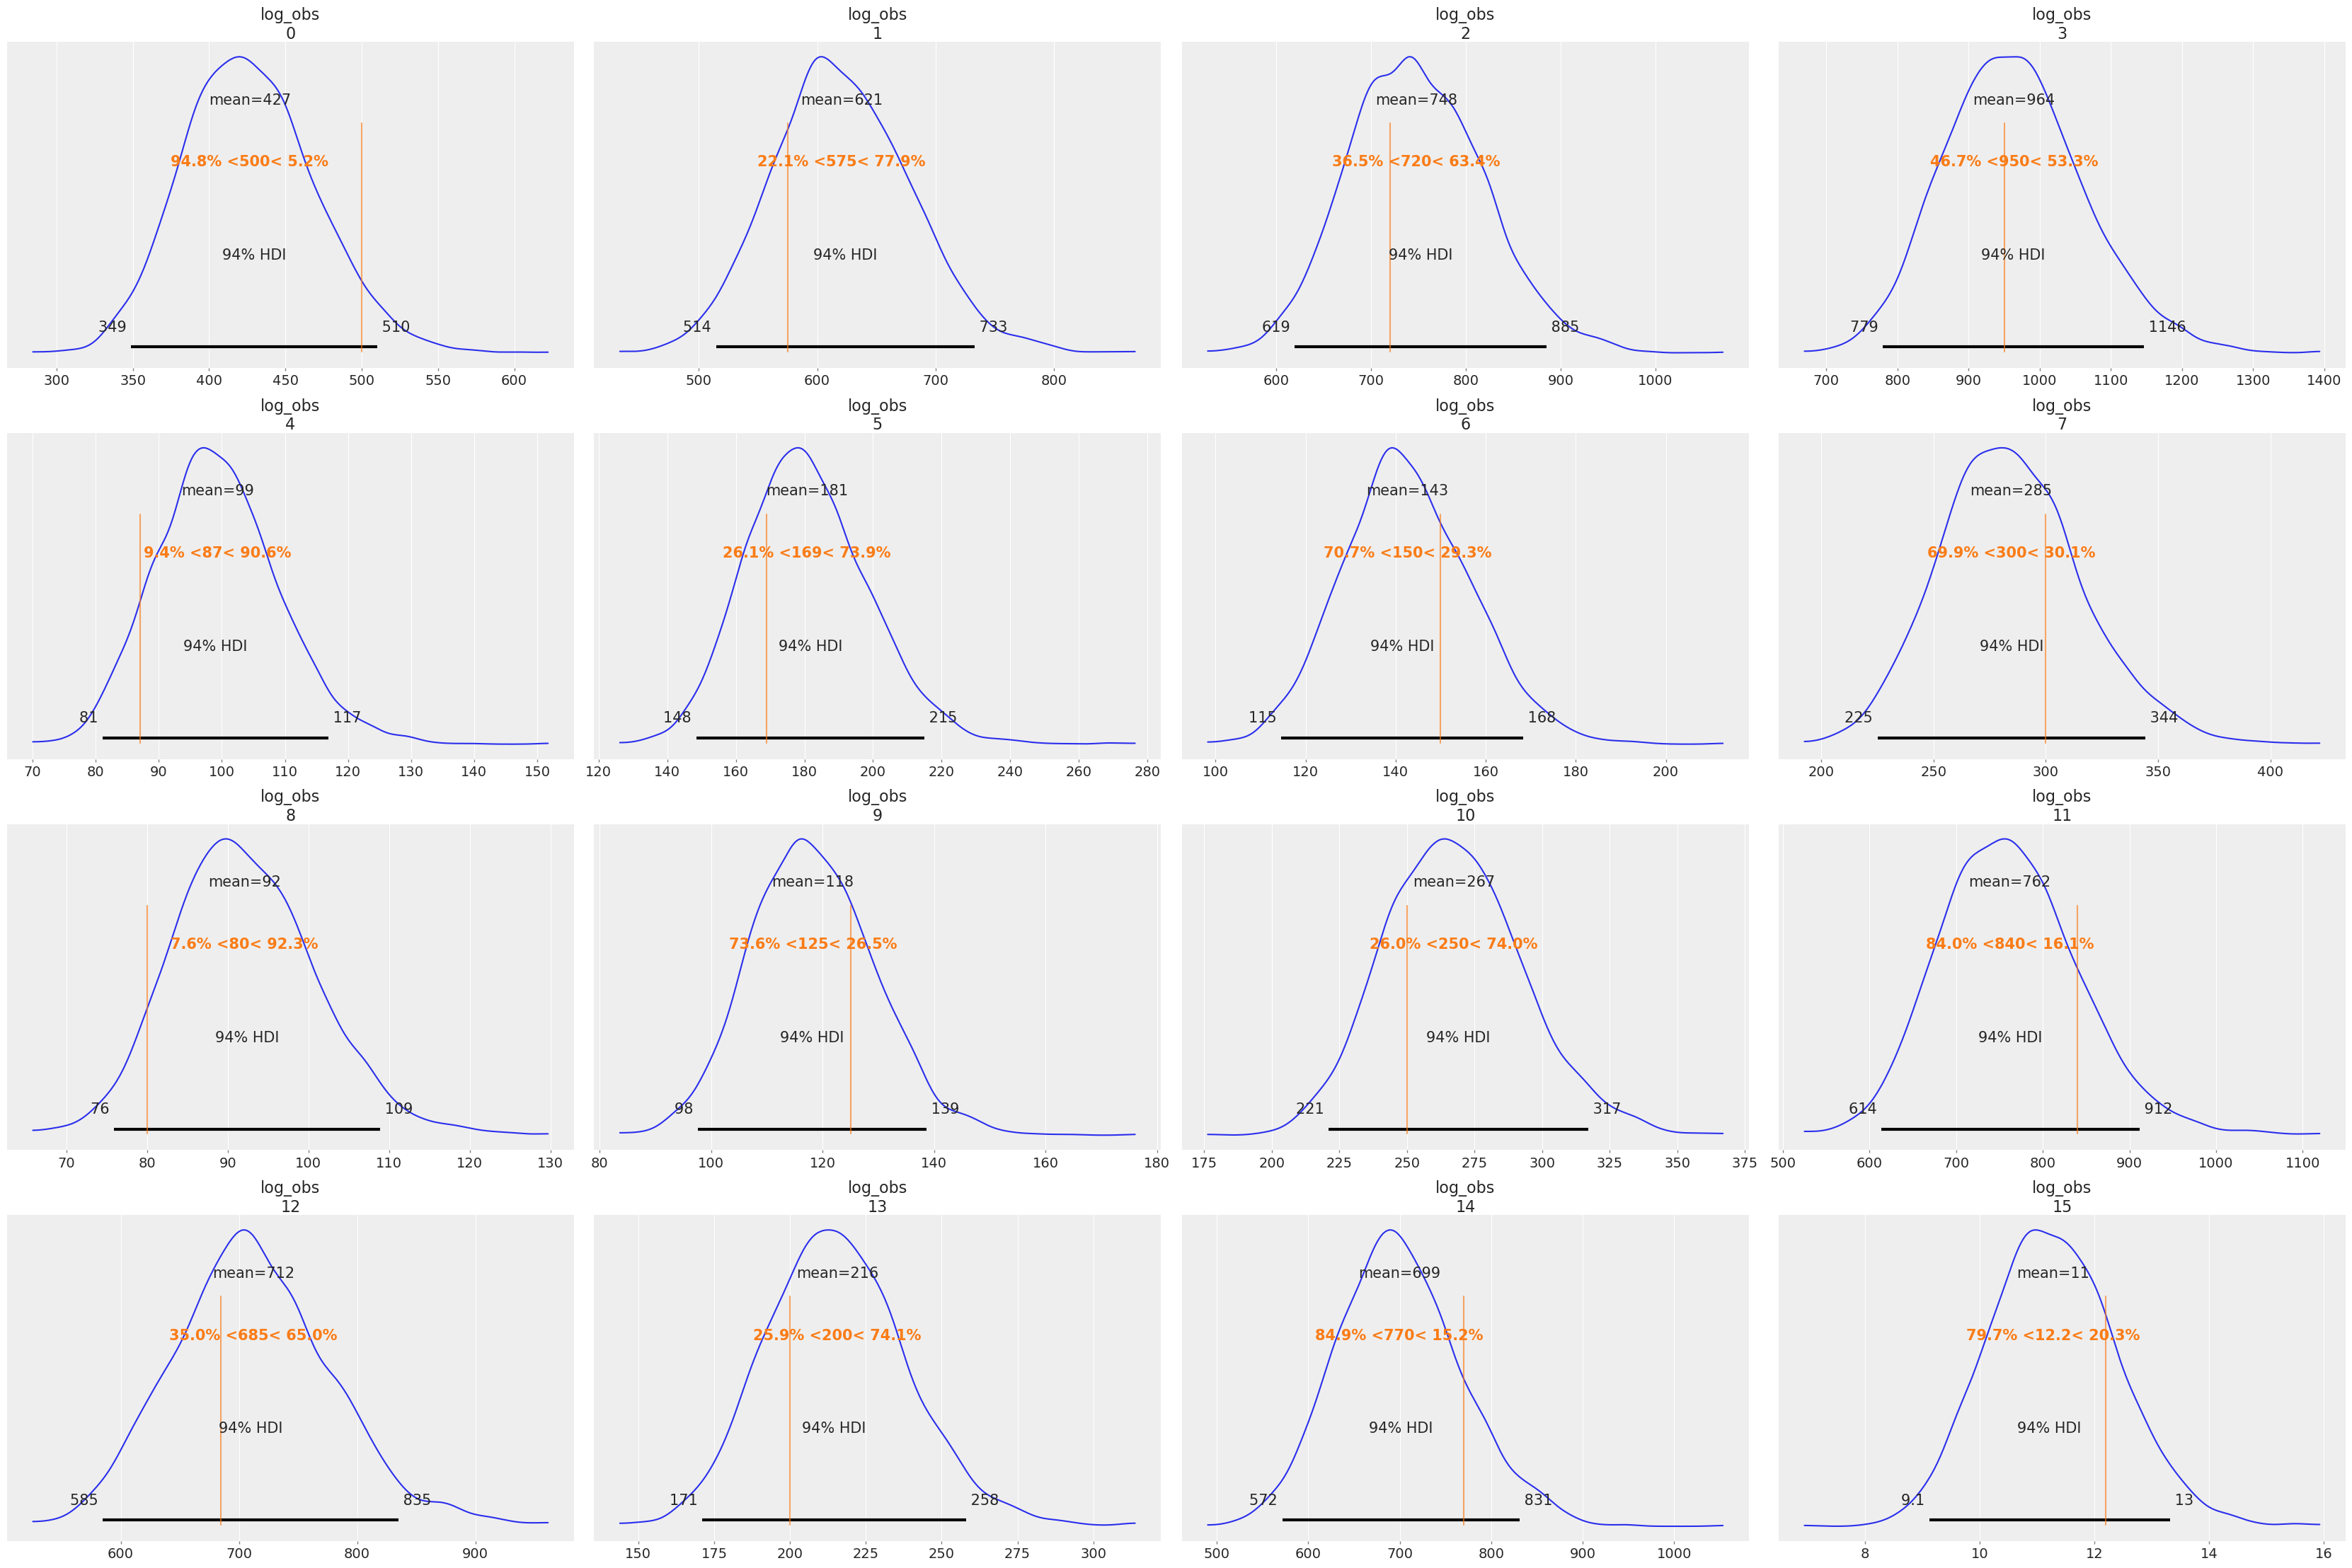

In [40]:
az.plot_posterior(
    idata_unpooled_oos.predictions,
    ref_val=fish_test["Weight"].tolist(),
    transform=np.exp,
);

Look at that beauty! The model did an excellent job predicting those new weights: the true value is inside the inferred posterior distribution for _every_ new data point, without extremely small probabilities.

### Section recap

- Use `pm.set_data` to update the values of predictors
- `pm.sample_posterior_predictive(predictions=True, extend_inferencedata=True)` uses the updated values to predict outcomes and appends them to the original `InferenceData` object
- `az.plot_posterior` is an easy and concise way to check the quality of and uncertainty in those predictions

## From predictions to business insights

Last step: remember what we said at the beginning? There are different price tiers for weights, and those tiers can get _really_ expensive, so we want to know the probability of an item being above any theshold. Since we have posterior samples, we can actually compute that probability for all the new fish we observed.

As in the previous plot, we'll exponentiate the predictions, so that we're on the data scale. The new thing is that, for each new fish, we'll compute the probability that it's above any of the four threshold.

How do we do that? We just count, as you saw in the first lesson! For each posterior prediction, we check if it's below the threshold. If it is, the value `True` is recorded; if it's not, then it's `False`. For instance, if the threshold is 250:

In [135]:
predictions = np.exp(idata_unpooled_oos.predictions)

In [139]:
threshold = 250
(predictions >= threshold)

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 1000, log_obs_dim_0: 16)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * log_obs_dim_0  (log_obs_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    log_obs        (chain, draw, log_obs_dim_0) bool True True ... True False
Attributes:
    created_at:                 2022-01-07T11:31:03.996790
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b1

Then, we just have to take the mean of this object across chains and draws, and it's our probability!

## Lesson recap